# Building Random Forest Algorithm
## Writing the algorithm in set of  functions

In [1]:
#importing modules to perform basic operations
from random import seed
from random import randrange
from math import sqrt

In [2]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split


In [3]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


In [4]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores


In [5]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right


In [6]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini


In [7]:
# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}


In [8]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)


In [9]:
# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root


In [10]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [11]:
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [12]:
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)


# Random Forest Algorithm
trees = list()
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)


# Test the random forest algorithm
seed(2)

## Loading the data into dataframe

In [13]:
# load and prepare data
filename = 'dataset_files/strokes.csv'
import pandas as pd
df= pd.read_csv(filename)

In [14]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Cleaning and Formatting the data

In [15]:
#deleteing unrelated column
#id - id of the patient maintained to detect stroke
del df['id']

In [16]:
#Printing the dataframe to see the data
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### The DataFrame columns contain String values. These string values are encoded into integer values.

In [17]:
#finding unique values in a column to convert
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [18]:
#converting String values to numerical data
# import required libraries
import pandas as pd
import numpy as np
# creating initial dataframe
bridge_types = ('Male','Female','Other')
# converting type of columns to 'category'
df['gender'] = df['gender'].astype('category')
# Assigning numerical values and storing in another column
df['gender'] = df['gender'].cat.codes
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,0,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1,58.0,1,0,No,Private,Urban,55.78,27.5,smokes,0
295,0,3.0,0,0,No,children,Urban,73.74,16.0,Unknown,0
296,0,58.0,0,0,Yes,Private,Urban,149.75,27.0,Unknown,0
297,1,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [19]:
#finding unique values in a column to convert
df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [20]:
#converting String values to numerical data
# creating initial dataframe
bridge_types = ('Yes','No')
# converting type of columns to 'category'
df['ever_married'] = df['ever_married'].astype('category')
# Assigning numerical values and storing in another column
df['ever_married'] = df['ever_married'].cat.codes
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,0,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,0,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1,58.0,1,0,0,Private,Urban,55.78,27.5,smokes,0
295,0,3.0,0,0,0,children,Urban,73.74,16.0,Unknown,0
296,0,58.0,0,0,1,Private,Urban,149.75,27.0,Unknown,0
297,1,14.0,0,0,0,Govt_job,Urban,82.34,31.6,Unknown,0


In [21]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [22]:
# creating initial dataframe
bridge_types = ('Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked')
# converting type of columns to 'category'
df['work_type'] = df['work_type'].astype('category')
# Assigning numerical values and storing in another column
df['work_type'] = df['work_type'].cat.codes
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,Urban,228.69,36.6,formerly smoked,1
1,0,61.0,0,0,1,3,Rural,202.21,NaN,never smoked,1
2,1,80.0,0,1,1,2,Rural,105.92,32.5,never smoked,1
3,0,49.0,0,0,1,2,Urban,171.23,34.4,smokes,1
4,0,79.0,1,0,1,3,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1,58.0,1,0,0,2,Urban,55.78,27.5,smokes,0
295,0,3.0,0,0,0,4,Urban,73.74,16.0,Unknown,0
296,0,58.0,0,0,1,2,Urban,149.75,27.0,Unknown,0
297,1,14.0,0,0,0,0,Urban,82.34,31.6,Unknown,0


In [23]:
df['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [24]:
# creating initial dataframe
bridge_types = ('Urban', 'Rural')
# converting type of columns to 'category'
df['Residence_type'] = df['Residence_type'].astype('category')
# Assigning numerical values and storing in another column
df['Residence_type'] = df['Residence_type'].cat.codes
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,formerly smoked,1
1,0,61.0,0,0,1,3,0,202.21,NaN,never smoked,1
2,1,80.0,0,1,1,2,0,105.92,32.5,never smoked,1
3,0,49.0,0,0,1,2,1,171.23,34.4,smokes,1
4,0,79.0,1,0,1,3,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1,58.0,1,0,0,2,1,55.78,27.5,smokes,0
295,0,3.0,0,0,0,4,1,73.74,16.0,Unknown,0
296,0,58.0,0,0,1,2,1,149.75,27.0,Unknown,0
297,1,14.0,0,0,0,0,1,82.34,31.6,Unknown,0


In [25]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [26]:
# creating initial dataframe
bridge_types = ('formerly smoked', 'never smoked', 'smokes', 'Unknown')
# converting type of columns to 'category'
df['smoking_status'] = df['smoking_status'].astype('category')
# Assigning numerical values and storing in another column
df['smoking_status'] = df['smoking_status'].cat.codes
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
294,1,58.0,1,0,0,2,1,55.78,27.5,3,0
295,0,3.0,0,0,0,4,1,73.74,16.0,0,0
296,0,58.0,0,0,1,2,1,149.75,27.0,0,0
297,1,14.0,0,0,0,0,1,82.34,31.6,0,0


# Data Visualization.
### Checking the co-relation between the columns

#### 1. Heat Map

<AxesSubplot:>

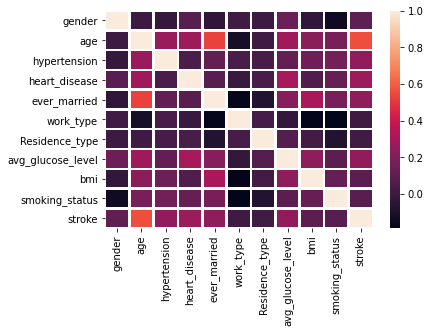

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=1.5)

#### 2.regplot() - It performs a simple linear regression model fit and plot. 

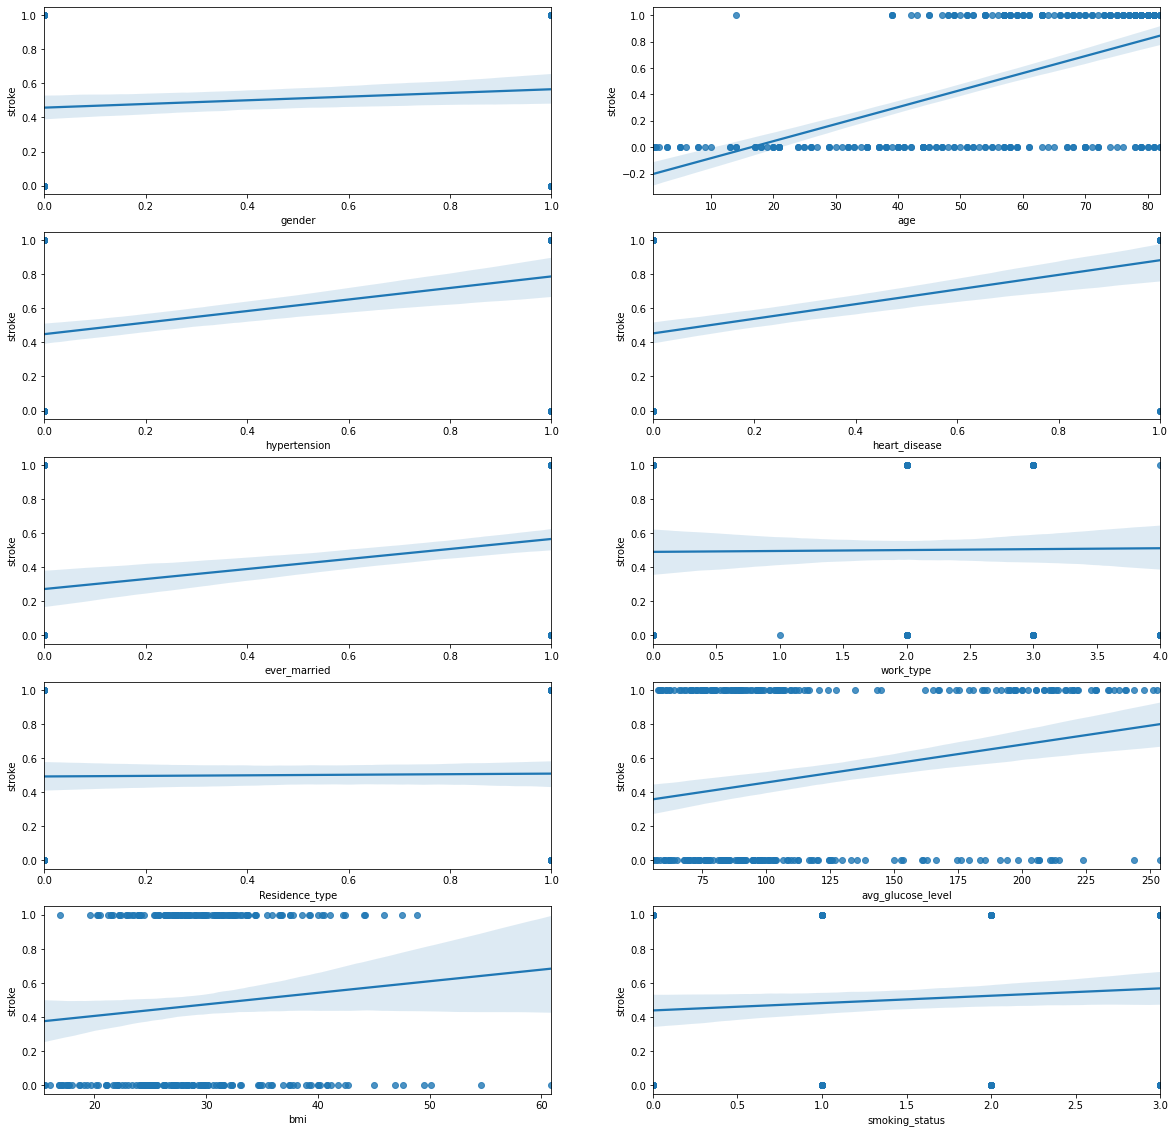

In [28]:
fig ,axis = plt.subplots(nrows=5,ncols=2,figsize=(20,20))
count=0
for i in range(5):
    for j in range(2):
        sns.regplot(x=df.iloc[:,count],y='stroke',data=df, ax=axis[i,j])
        count+=1

In [29]:
#converting dataframe to list for random forest evaluation
data = df.values.tolist()

In [30]:
print(data)

[[1.0, 67.0, 0.0, 1.0, 1.0, 2.0, 1.0, 228.69, 36.6, 1.0, 1.0], [0.0, 61.0, 0.0, 0.0, 1.0, 3.0, 0.0, 202.21, nan, 2.0, 1.0], [1.0, 80.0, 0.0, 1.0, 1.0, 2.0, 0.0, 105.92, 32.5, 2.0, 1.0], [0.0, 49.0, 0.0, 0.0, 1.0, 2.0, 1.0, 171.23, 34.4, 3.0, 1.0], [0.0, 79.0, 1.0, 0.0, 1.0, 3.0, 0.0, 174.12, 24.0, 2.0, 1.0], [1.0, 81.0, 0.0, 0.0, 1.0, 2.0, 1.0, 186.21, 29.0, 1.0, 1.0], [1.0, 74.0, 1.0, 1.0, 1.0, 2.0, 0.0, 70.09, 27.4, 2.0, 1.0], [0.0, 69.0, 0.0, 0.0, 0.0, 2.0, 1.0, 94.39, 22.8, 2.0, 1.0], [0.0, 59.0, 0.0, 0.0, 1.0, 2.0, 0.0, 76.15, nan, 0.0, 1.0], [0.0, 78.0, 0.0, 0.0, 1.0, 2.0, 1.0, 58.57, 24.2, 0.0, 1.0], [0.0, 81.0, 1.0, 0.0, 1.0, 2.0, 0.0, 80.43, 29.7, 2.0, 1.0], [0.0, 61.0, 0.0, 1.0, 1.0, 0.0, 0.0, 120.46, 36.8, 3.0, 1.0], [0.0, 54.0, 0.0, 0.0, 1.0, 2.0, 1.0, 104.51, 27.3, 3.0, 1.0], [1.0, 78.0, 0.0, 1.0, 1.0, 2.0, 1.0, 219.84, nan, 0.0, 1.0], [0.0, 79.0, 0.0, 1.0, 1.0, 2.0, 1.0, 214.09, 28.2, 2.0, 1.0], [0.0, 50.0, 1.0, 0.0, 1.0, 3.0, 0.0, 167.41, 30.9, 2.0, 1.0], [1.0, 64.0, 0.0

## Evaluating the algorithm 

In [31]:
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(data[0])-1))
for n_trees in [1, 5, 10]:
    scores = evaluate_algorithm(data, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [66.10169491525424, 74.57627118644068, 72.88135593220339, 81.35593220338984, 98.30508474576271]
Mean Accuracy: 78.644%
Trees: 5
Scores: [84.7457627118644, 94.91525423728814, 91.52542372881356, 96.61016949152543, 96.61016949152543]
Mean Accuracy: 92.881%
Trees: 10
Scores: [94.91525423728814, 96.61016949152543, 94.91525423728814, 100.0, 96.61016949152543]
Mean Accuracy: 96.610%


## Providing desired test instance for evaluating the algorithm

In [32]:
def testing():
    testdata1=[1.0, 80.0, 0.0, 1.0, 1.0, 2.0, 0.0, 105.92, 32.5, 2.0]
    predict = bagging_predict(trees, testdata1)
    print(predict)

In [33]:
testing()

1.0


## Comparing the model with Sklearn builtin ensemble Random Forest algorithm

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
df.isnull().sum()

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  27
smoking_status        0
stroke                0
dtype: int64

In [35]:
df=df.dropna()

In [36]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],test_size=0.3,random_state=1)
x_columns=df.iloc[:,0:-1].columns
print('x_train and x_test shape',x_train.shape,'&',x_test.shape)
print('y_train and y_test shape',y_train.shape,'&',y_test.shape)

x_train and x_test shape (190, 10) & (82, 10)
y_train and y_test shape (190,) & (82,)


In [37]:
#random forest classifier
rf= RandomForestClassifier()
rf.fit(x_train,y_train)
y_predict=rf.predict(x_test)
wrong = (y_test != y_predict).sum()
print("Random Forest Classifier ")
print("Misclassified samples: ",wrong)
rfcacc = metrics.accuracy_score(y_test,y_predict)
print("accuracy: ",rfcacc)

Random Forest Classifier 
Misclassified samples:  16
accuracy:  0.8048780487804879


## Thank you!